In [10]:
from Reader import Reader
import copy
import json
import sys
import os
import time
from glob import glob
import argparse
import _pickle as cPickle
import subprocess as sp
import multiprocessing as mp
from collections import deque

import numpy as np
import pandas as pd
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model as lm
import seaborn as sns
from matplotlib import pyplot as plt

from run_model import *
import root_pandas as rp
import uproot

### Parameters definition

In [12]:
channel = 'mt'
era = '2017'
samples = f'conf/global_config_{channel}_{era}.json'
use = 'keras'

# train = False
# short = True
# datacard = False
# add_nominal = False

In [13]:
read = Reader(channel = channel, config_file = samples, folds=2, era = era)

In [14]:
target_names = read.config["target_names"]
variables = read.config["variables"]

models_folder = era + "/models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

modelname = f'{models_folder}/{channel}.{use}'
scaler = None

### Tests for Reader()

In [5]:
read.config['samples']['qqH125']

{'target': 0,
 'select': 'q_1 * q_2 < 0 & byMediumDeepTau2017v2p1VSjet_2 > 0.5 & iso_1 < 0.15 & ((extramuon_veto < 0.5) & (extraelec_veto < 0.5) & (dilepton_veto<0.5) & (byVLooseDeepTau2017v2p1VSmu_2>0.5) & (byVVVLooseDeepTau2017v2p1VSe_2>0.5) ) & puppimt_1 < 50 & ( ( (trg_mutaucross & abs(eta_1) < 2.1 & pt_1 < 25) | trg_singlemuon  ) & pt_2 > 30 )',
 'name': '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/HiggsCP/Inputs/Systematics_v1/NTuples_mt_2017/mt-NOMINAL_ntuple_VBF.root',
 'event_weight': '( gen_sm_htt125 * weight * ( 0.95+0.02*( (jpt_1>0 & jpt_1<200) & (njets<2 | ( (jdeta<2.8 | mjj<400 ) & (mjj<60 | mjj>=120 ) ) ) ) - 0.1*(jpt_1>=200) ) * ( 0.89*(gen_match_2 == 5) + 1.*(gen_match_2 !=5) ) )',
 'target_name': 'higgs'}

In [6]:
read.config['target_names']

{0: 'higgs', 1: 'ztt', 2: 'tt', 3: 'fakes', -1: 'none'}

In [7]:
read.config['samples']['W']['target']

3

In [8]:
read.config['samples']['W']['target_name']

'fakes'

### Tests for uproot 

In [6]:
mytree = uproot.open(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root')['TauCheck_CMS_scale_j_JES13TeVUp']
mydf = mytree.pandas.df()

In [10]:
mydf.columns

Index(['run', 'lumi', 'evt', 'npv', 'npu', 'rho', 'passedAllMetFilters',
       'pt_1', 'phi_1', 'eta_1',
       ...
       'xsec_lumi_weight', 'qcd_correction', 'trigger_filter_weight',
       'embedded_stitching_weight', 'embedded_rate_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys'],
      dtype='object', length=403)

#### all branches

In [76]:
%%timeit
df_up = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVUp')

23.8 s ± 4.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit
df_up = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVUp', chunksize=10000)

15.2 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
mytree = uproot.open(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root')['TauCheck_CMS_scale_j_JES13TeVUp']
mydf = mytree.pandas.df()

4.25 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
mytree = uproot.open(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root')['TauCheck_CMS_scale_j_JES13TeVUp']

#### one branch

In [80]:
%%timeit
df_up = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', columns = 'pt_2', key='TauCheck_CMS_scale_j_JES13TeVUp')

61.1 ms ± 4.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%%timeit
df_up = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', columns = 'pt_2', key='TauCheck_CMS_scale_j_JES13TeVUp', chunksize=10000)

16.2 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [82]:
%%timeit
mytree = uproot.open(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root')['TauCheck_CMS_scale_j_JES13TeVUp']
mydf = mytree.pandas.df(branches='pt_2')

298 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Tests for systematic samples

In [9]:
df_up = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVUp')
df_down = rp.read_root(read.config['path'] + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVDown')

In [10]:
df_up.shape[0], df_down.shape[0]

(367945, 367945)

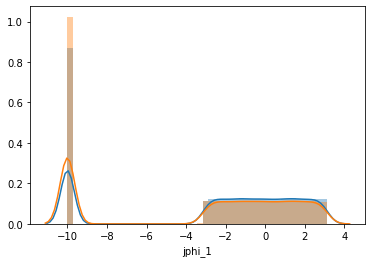

In [11]:
sns.distplot(df_up.jphi_1)
sns.distplot(df_down.jphi_1)

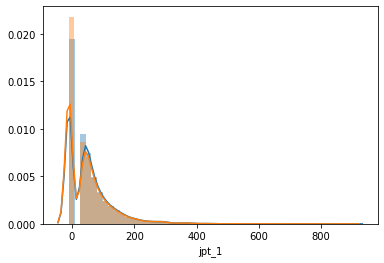

In [12]:
sns.distplot(df_up.jpt_1)
sns.distplot(df_down.jpt_1)

In [13]:
np.argwhere((df_up.values - df_down.values) != 0)

array([[    1,   237],
       [    1,   240],
       [    1,   241],
       ...,
       [10847,   237],
       [10847,   238],
       [10847,   242]])

In [14]:
df_up.columns[238]

'jpt_1'

In [12]:
df_up.jphi_1.mean(), df_down.jphi_1.mean()

(-2.2917929, -3.0601332)

In [16]:
df_up.jpt_1.mean(), df_down.jpt_1.mean()

(54.525555, 51.109432)

In [13]:
df_up.columns

Index(['run', 'lumi', 'evt', 'npv', 'npu', 'rho', 'passedAllMetFilters',
       'pt_1', 'phi_1', 'eta_1',
       ...
       'xsec_lumi_weight', 'qcd_correction', 'trigger_filter_weight',
       'embedded_stitching_weight', 'embedded_rate_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys'],
      dtype='object', length=403)

### **Training data + scaling**

In [9]:
%%time
trainSet = read.getSamplesForTraining()

Loading: TJ from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TJ is 2661
Loading: TL from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TL is 7475
Loading: TT from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TT is 1069
Loading: TTJ from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTJ is 50846
Loading: TTL from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTL is 267199
Loading: TTT from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTT is 33900
Loading: VVJ from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVJ is 938
Loading: VVL from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVL is 2773
Loading: VVT from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVT is 1365
Loading: W from mt-NOMINAL_ntuple_WJets.root, tree = TauCheck
size of W is 13093
Loading: ZJ from mt-NOMINAL_ntuple_DY.root, tree = TauCheck
size of ZJ is 3225
Loading: ZL from mt-NOMINAL_ntuple_DY.root, tree = TauCheck
size of ZL is 11310
Loading: ZTT 

In [6]:
scaler = trainScaler(trainSet, variables )
with open("{0}/StandardScaler.{1}.pkl".format(models_folder,channel), 'wb') as FSO:
    pickle.dump(scaler, FSO , 2)
scaler = [scaler, scaler] # Hotfix since KIT uses 2 scalers
trainSet = applyScaler(scaler, trainSet, variables)

### Tests with trainSet

In [7]:
trainSet[1].head()

,pt_2,jpt_1,jpt_2,bpt_1,bpt_2,njets,nbtag,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
0,-0.128386,-0.434617,-0.857003,-0.702024,-0.386620,-0.495468,-0.764144,0.292863,-0.769139,-0.786940,-0.514608,-1.038578,-0.770740,3,97.100000,1673128920,1.000000
1,0.224279,-1.079529,-0.857003,-0.702024,-0.386620,-1.189380,-0.764144,-1.218558,-1.011034,-1.191012,-0.514608,-1.038578,-0.770740,0,34066.981871,3629284,1462.102226
2,-0.792258,-1.079529,-0.857003,-0.702024,-0.386620,-1.189380,-0.764144,-1.218558,-0.439283,-0.713931,-0.514608,-1.038578,-0.770740,3,97.100000,106046432,1.000000
3,0.328201,-0.071782,0.356838,-0.702024,-0.386620,0.198443,-0.764144,-0.065288,0.192986,0.685037,7.386427,1.907933,0.784578,0,4116.341280,2685572,176.667008
4,-0.696759,0.407153,0.887142,0.812773,1.129923,0.198443,3.163842,0.205837,-1.153561,0.168587,0.053825,0.814356,0.640418,2,3698.600846,54744718,3362.364406


In [19]:
data = trainSet[1]

In [20]:
data.columns

Index(['pt_2', 'pt_2', 'jpt_1', 'jpt_2', 'bpt_1', 'bpt_2', 'njets', 'nbtag',
       'm_sv', 'puppimt_1', 'puppimt_1', 'pt_tt', 'pt_tt', 'mjj', 'jdeta',
       'dijetpt', 'target', 'train_weight', 'evt', 'event_weight'],
      dtype='object')

In [21]:
np.unique(data.target)

array([0, 1, 2, 3])

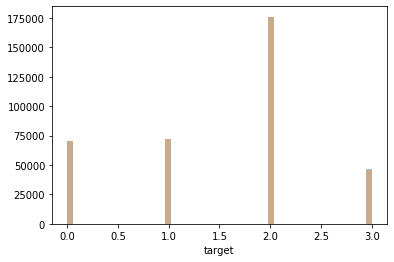

In [22]:
sns.distplot(trainSet[0].target, kde=False)
sns.distplot(trainSet[1].target, kde=False)

In [23]:
trainSet[0].shape[0] + trainSet[1].shape[0]

729702

### **Defining model and training**

In [8]:
if use == 'keras':
    from KerasModel import KerasObject as modelObject
    parameters = "conf/parameters_keras.json"
if use == 'xgb':
    from XGBModel import XGBObject as modelObject
    parameters = "conf/parameters_xgb.json"

In [6]:
model = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )


In [7]:
model.params

{'name': 'smhtt_dropout_tanh',
 'batch_size': 100,
 'epochs': 10,
 'early_stopping': 50}

In [10]:
model.variables

['pt_2',
 'jpt_1',
 'jpt_2',
 'bpt_1',
 'bpt_2',
 'njets',
 'nbtag',
 'm_sv',
 'puppimt_1',
 'pt_tt',
 'mjj',
 'jdeta',
 'dijetpt']

In [11]:
model.train( trainSet )



i am the beginning




i am before here


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2800      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (No

2020-01-09 11:22:40.230061: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [12]:
model.models

In [37]:
modelname

'2017/models/mt.keras'

In [38]:
model.__dict__

{'variables': ['pt_2',
  'jpt_1',
  'jpt_2',
  'bpt_1',
  'bpt_2',
  'njets',
  'nbtag',
  'm_sv',
  'puppimt_1',
  'pt_tt',
  'mjj',
  'jdeta',
  'dijetpt'],
 'models': [<keras.models.Sequential at 0x2b801c66aa20>,
 'params': {'name': 'smhtt_dropout_tanh',
  'batch_size': 1000000,
  'epochs': 10,
  'early_stopping': 50},
 'target_names': {0: 'higgs', 1: 'ztt', 2: 'tt', 3: 'fakes', -1: 'none'}}

In [39]:
# Save models
model.models[0].save(modelname + "_10epochs_nobatch.fold0")
model.models[1].save(modelname + "_10epochs_nobatch.fold1")

### Load model

In [9]:
model_loaded = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )

In [10]:
model_loaded.models = []
model_loaded.models.append( lm(modelname + "_10epochs.fold0") )
model_loaded.models.append( lm(modelname + "_10epochs.fold1") )


2020-01-15 20:39:04.098468: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [11]:
model_loaded.__dict__

{'variables': ['pt_2',
  'jpt_1',
  'jpt_2',
  'bpt_1',
  'bpt_2',
  'njets',
  'nbtag',
  'm_sv',
  'puppimt_1',
  'pt_tt',
  'mjj',
  'jdeta',
  'dijetpt'],
 'models': [<keras.models.Sequential at 0x2b7462cc4c50>,
 'params': {'name': 'smhtt_dropout_tanh',
  'batch_size': 100,
  'epochs': 10,
  'early_stopping': 50},
 'target_names': {0: 'higgs', 1: 'ztt', 2: 'tt', 3: 'fakes', -1: 'none'}}

### Prediction

In [12]:
from run_model import sandbox

In [16]:
outpath = read.config["outpath"] + "/predictions_" + era
if not os.path.exists(outpath):
    os.mkdir(outpath)    
predictions = {}

In [14]:
# Deleting root files in outpath
files = glob(outpath + '/*.root')
for f in files:
    os.remove(f)

In [15]:
%%time
for sample, sampleConfig in read.get(what = "full", add_jec = True, for_prediction = True):
    if "data" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables, "NOMINAL_ntuple_Data", outpath, sampleConfig, read.modifyDF)
    elif "full" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables,  "NOMINAL_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )
    else:
        splName = sampleConfig["histname"].split("_")
        sandbox(channel, model_loaded, scaler, sample, variables,  "_".join(splName[1:])+"_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )

Loading: DY_full from mt-NOMINAL_ntuple_DY.root, tree = TauCheck
Loading: DY_full from mt-NOMINAL_ntuple_DY.root, tree = TauCheck_CMS_scale_j_JES13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DY.root, tree = TauCheck_CMS_scale_j_JES13TeVDown
Loading: ST_full from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
Loading: ST_full from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck_CMS_scale_j_JES13TeVUp
Loading: ST_full from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck_CMS_scale_j_JES13TeVDown
Loading: TT_full from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
Loading: TT_full from mt-NOMINAL_ntuple_TT.root, tree = TauCheck_CMS_scale_j_JES13TeVUp
Loading: TT_full from mt-NOMINAL_ntuple_TT.root, tree = TauCheck_CMS_scale_j_JES13TeVDown
Loading: VV_full from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
Loading: VV_full from mt-NOMINAL_ntuple_VV.root, tree = TauCheck_CMS_scale_j_JES13TeVUp
Loading: VV_full from mt-NOMINAL_ntuple_VV.root, tree = TauCheck_CMS_scale_j_JES13TeVDown
Loading

### Tests with NN predictions

In [17]:
DY_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVUp')
DY_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_JES13TeVDown')
DY_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck')

OSError: cannot read /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/outputs/predictions_2017/mt-NOMINAL_ntuple_DY.root

Error in <TFile::TFile>: file /nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/outputs/predictions_2017/mt-NOMINAL_ntuple_DY.root does not exist


In [ ]:
ggH_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_JES13TeVUp')
ggH_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_JES13TeVDown')
ggH_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck')

Text(0.5, 1.0, 'DY')

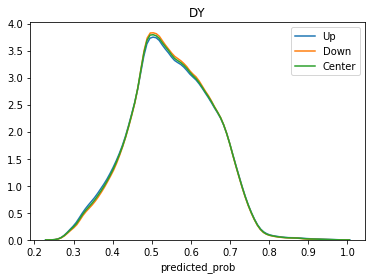

In [49]:
sns.distplot(DY_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(DY_predict_down.predicted_prob, label='Down', hist=False)
sns.distplot(DY_predict_center.predicted_prob, label='Center', hist=False)
plt.legend()
plt.title('DY')

Text(0.5, 1.0, 'ggH')

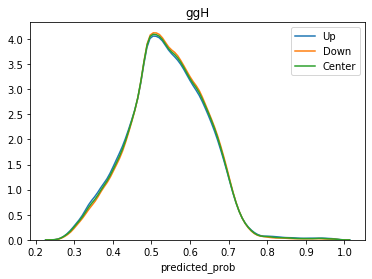

In [50]:
sns.distplot(ggH_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(ggH_predict_down.predicted_prob, label = 'Down', hist=False)
sns.distplot(ggH_predict_center.predicted_prob, label = 'Center', hist=False)
plt.legend()
plt.title('ggH')